# Privacy Policy Text Classifier

### This ML model is able to detect if a text is a policy or not. It is tested with root resources of domains recovered from web page published in Google Play store for each app

Importing the manually annotated dataset. Dropping empty pages and suffling the dataframe aftwerwards.

In [23]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv('ispolicy_annotated.csv', sep=';')
df = df.dropna(subset=['text'])
df = shuffle(df)
df

,apk,text,Ispolicy
49,com.nianticlabs.pokemongo,Niantic Support\n\nPokémon GO Help Center\n\nP...,False
58,com.playtika.wsop.gp,Please note: This website includes an accessib...,False
104,com.coinbase.android,One more step\nPlease complete the security ch...,False
46,com.moonactive.coinmaster,"Please stand by, while we are checking your br...",False
57,com.playstudios.popslots,PLAYSTUDIOS ACCESSIBILITY STATEMENT\n\nPLAYSTU...,False
...,...,...,...
59,com.productmadness.cashmancasino,"With a swashbuckling, can-do attitude and a he...",False
125,com.gsn.android.tripeaks,"GSN PRIVACY POLICY\n\nEffective Date: May 27, ...",True
112,com.dts.freefireth,HOME\nGAME\nNEWS\nMEDIA\nSUPPORT\nESPORTS\nMAX...,True
72,com.tool.fast.smart.cleaner,Welcome To Smart Cleaner\n\nSmart Cleaner is a...,False


## Distribution of the dataset

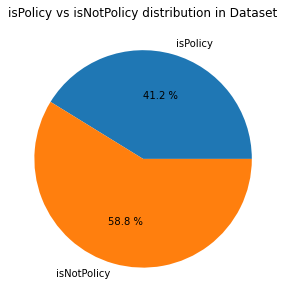

In [31]:
import matplotlib.pyplot as plt

label = ['isPolicy', 'isNotPolicy']
data = [len(df[df['Ispolicy'].__eq__(True)]), len(df[df['Ispolicy'].__eq__(False)])]

fig = plt.figure(figsize =(8, 5))
plt.pie(data, labels = label, autopct="%0.1f %%")
plt.title('isPolicy vs isNotPolicy distribution in Dataset')
# show plot
plt.show()

### Text processing, tokenization, stopwords, punctuation marks, lematizing...

In [25]:
import string
import nltk
import re

#nltk.download('stopwords')
#nltk.download('wordnet')
stopword = nltk.corpus.stopwords.words('english')

def remove_punct(text):
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in stopword]
    return text

# Se reduce la palabra pero puede ser a una que no exista en ese lenguaje (normalmente se trunca la palabra)
ps = nltk.PorterStemmer()
def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

# La palabra se reduce a una que existe en ese lenguaje
# Ejemplo de lemmatization: eating -> eat
wn = nltk.WordNetLemmatizer()
def lemmatizing(tokenized_text):
    text = "".join([wn.lemmatize(word + ' ') for word in tokenized_text])
    return text

# PROCESAMIENTO DE TEXTO Nueva Columna (processed_text)

# LOWER CASE
df['processed_text'] = df['text'].apply(lambda x: x.lower())
# REMOVE PUNCTUATION
df['processed_text'] = df['processed_text'].apply(lambda x: remove_punct(x))
# TOKENIZACION
df['processed_text'] = df['processed_text'].apply(lambda x: tokenize(x))

# REMOVE STOPWORDS
#df['wordcloud'] = df['processed_text'].apply(lambda x: remove_stopwords(x))
df['processed_text'] = df['processed_text'].apply(lambda x: remove_stopwords(x))

# Stemming OPTIONAL (Stemming es más rápido pero lo que hace normalmente es truncar el final de las palabras)
#df['processed_sentence_text'] = df['processed_sentence_text'].apply(lambda x: stemming(x))
# Lemmatizing se tiene en cuenta el contexto de las palabras para dejar la palabra raíz de la que deriva
df['processed_text'] = df['processed_text'].apply(lambda x: lemmatizing(x))

df = df.reset_index()

df

,index,apk,text,Ispolicy,processed_text
0,49,com.nianticlabs.pokemongo,Niantic Support\n\nPokémon GO Help Center\n\nP...,False,niantic support pokémon go help center popular...
1,58,com.playtika.wsop.gp,Please note: This website includes an accessib...,False,please note website includes accessibility sys...
2,104,com.coinbase.android,One more step\nPlease complete the security ch...,False,one step please complete security check access...
3,46,com.moonactive.coinmaster,"Please stand by, while we are checking your br...",False,please stand checking browser rayid 6dee9fe6cc...
4,57,com.playstudios.popslots,PLAYSTUDIOS ACCESSIBILITY STATEMENT\n\nPLAYSTU...,False,playstudios accessibility statement playstudio...
...,...,...,...,...,...
160,59,com.productmadness.cashmancasino,"With a swashbuckling, can-do attitude and a he...",False,swashbuckling cando attitude healthy dose crea...
161,125,com.gsn.android.tripeaks,"GSN PRIVACY POLICY\n\nEffective Date: May 27, ...",True,gsn privacy policy effective date may 27 2021 ...
162,112,com.dts.freefireth,HOME\nGAME\nNEWS\nMEDIA\nSUPPORT\nESPORTS\nMAX...,True,home game news media support esports max priva...
163,72,com.tool.fast.smart.cleaner,Welcome To Smart Cleaner\n\nSmart Cleaner is a...,False,welcome smart cleaner smart cleaner free mobil...


### Dividing dataframe in traning and test sets

In [26]:
from sklearn.model_selection import train_test_split

# Output
y = df.Ispolicy
# Input
X = df['processed_text']

# Conjuntos de entrenamiento y test -> 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Generating and training SVM Model

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import numpy as np
import sklearn.metrics
import joblib

# text_clf_svm es el modelo generado
text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))), 
                     ('tfidf', TfidfTransformer()), 
                     ('clf-svm', SGDClassifier(loss='modified_huber', penalty='l2', 
                                               class_weight='balanced', alpha=0.0001, 
                                               epsilon=0.1, eta0=0.5, power_t=0.5, 
                                               tol=None, learning_rate='adaptive', 
                                               fit_intercept=True))])

# Entrenamiento del modelo
_ = text_clf_svm.fit(X_train, y_train)

## Guardar el modelo SVM ya entrenado:
#joblib.dump(text_clf_svm, 'ham_spam_trained_model.pkl')

predicted_svm = text_clf_svm.predict(X_test)

### SVM Metrics

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score

def get_eval_metrics(real_Y, predicted_Y, positive_class=1, negative_class=0):
    metrics = {'precision': precision_score(real_Y, predicted_Y, pos_label=positive_class, average='binary'),
               'recall': recall_score(real_Y, predicted_Y, pos_label=positive_class, average='binary'),
               'f1-score': f1_score(real_Y, predicted_Y, pos_label=positive_class, average='binary'),
               'NVP': precision_score(real_Y, predicted_Y, pos_label=negative_class, average='binary'),
               'specificity': recall_score(real_Y, predicted_Y, pos_label=negative_class, average='binary'),
               'f1-score-negative': f1_score(real_Y, predicted_Y, pos_label=negative_class, average='binary'),
               'accuracy': balanced_accuracy_score(real_Y, predicted_Y)}
    tn, fp, fn, tp = confusion_matrix(real_Y, predicted_Y, labels=[positive_class, negative_class]).ravel()
    metrics['conf_matrix'] = [tn, fp, fn, tp]
    return metrics

get_eval_metrics(y_test, predicted_svm)

{'precision': 1.0,
 'recall': 1.0,
 'f1-score': 1.0,
 'NVP': 1.0,
 'specificity': 1.0,
 'f1-score-negative': 1.0,
 'accuracy': 1.0,
 'conf_matrix': [16, 0, 0, 26]}

### 5-Fold Cross Validation Metrics

In [29]:
from sklearn.model_selection import StratifiedKFold

def mean_metrics (metrics_lst):
    return {'precision': np.mean([m['precision'] for m in metrics_lst]),
            'recall': np.mean([m['recall'] for m in metrics_lst]),
            'f1-score': np.mean([m['f1-score'] for m in metrics_lst]),
            'NVP': np.mean([m['NVP'] for m in metrics_lst]),
            'specificity': np.mean([m['specificity'] for m in metrics_lst]),
            'f1-score-negative': np.mean([m['f1-score-negative'] for m in metrics_lst]),
            'accuracy': np.mean([m['accuracy'] for m in metrics_lst]),
            'confusion_matrix': [m['conf_matrix'] for m in metrics_lst]
            }

skf = StratifiedKFold(n_splits=5, random_state=None)
# X is the feature set and y is the target

mean_metrics_list_svm = []
for train_index, test_index in skf.split(X,y): 
    #print("Train:", train_index, "Validation:", test_index) 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    #predicted_svm = model_svm.predict(X_test)
    predicted_svm = text_clf_svm.predict(X_test) 
    mean_metrics_list_svm.append(get_eval_metrics(y_test, predicted_svm))
    #print(get_eval_metrics(y_test ,predicted_svm), '\n')
    
mean_metrics(mean_metrics_list_svm)

{'precision': 1.0,
 'recall': 1.0,
 'f1-score': 1.0,
 'NVP': 1.0,
 'specificity': 1.0,
 'f1-score-negative': 1.0,
 'accuracy': 1.0,
 'confusion_matrix': [[13, 0, 0, 20],
  [13, 0, 0, 20],
  [14, 0, 0, 19],
  [14, 0, 0, 19],
  [14, 0, 0, 19]]}

### Confussion Matrix

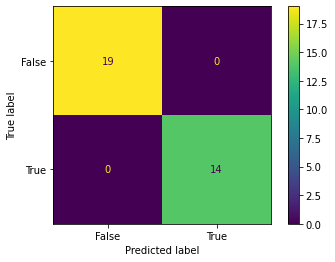

In [33]:
import matplotlib.pyplot as plt
sklearn.metrics.plot_confusion_matrix(text_clf_svm, X_test, y_test)

### Exporting Model

In [32]:
#joblib.dump(text_clf_svm, 'trained_ispolicy_classifier.pkl')

['trained_ispolicy_classifier.pkl']

# Validation

In [37]:
df_validation = pd.read_csv('./Validation/validation_annotated.csv', sep=';')
df_validation = df.dropna(subset=['text'])
df_validation = shuffle(df)
df_validation

,apk,text,Ispolicy
75,com.qidian.Int.reader,Browse\n \n Rankings\n \n Create\n Search...\n...,False
39,jp.pokemon.pokemonhome,・\nTHE POKÉMON COMPANY PRIVACY NOTICE FOR POKÉ...,True
63,com.google.android.apps.docs,Google Drive Help\nSign in\nHelp CenterCommuni...,False
0,co.hinge.app,Skip to main\nHinge homepage\nMission\nCareers...,True
67,com.linkedin.android,Skip to main content\n\nWe and third parties s...,False
...,...,...,...
77,com.taggedapp,The social network for meeting new people :)\n...,False
55,com.crunchyroll.crunchyroid,One more step\nPlease complete the security ch...,False
83,kik.android,skip to main content\nView High Contrast Site\...,False
59,com.duolingo,"The free, fun, and effective way to learn a la...",False


In [42]:
# PROCESAMIENTO DE TEXTO Nueva Columna (processed_text)

# LOWER CASE
df_validation['processed_text'] = df_validation['text'].apply(lambda x: x.lower())
# REMOVE PUNCTUATION
df_validation['processed_text'] = df_validation['processed_text'].apply(lambda x: remove_punct(x))
# TOKENIZACION
df_validation['processed_text'] = df_validation['processed_text'].apply(lambda x: tokenize(x))

# REMOVE STOPWORDS
df_validation['processed_text'] = df_validation['processed_text'].apply(lambda x: remove_stopwords(x))

# Lemmatizing se tiene en cuenta el contexto de las palabras para dejar la palabra raíz de la que deriva
df_validation['processed_text'] = df_validation['processed_text'].apply(lambda x: lemmatizing(x))

df_validation = df_validation.reset_index()

<ipython-input-42-d9febf086c4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation['processed_text'] = df_validation['text'].apply(lambda x: x.lower())
<ipython-input-42-d9febf086c4e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_validation['processed_text'] = df_validation['processed_text'].apply(lambda x: remove_punct(x))
<ipython-input-42-d9febf086c4e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

### Loading Model

In [43]:
isPolicyModel = joblib.load('trained_ispolicy_classifier.pkl')

### Predicting Validation Dataset

In [44]:
predicted_model = isPolicyModel.predict(df_validation['processed_text'])

### Validation Metrics

In [46]:
get_eval_metrics(df_validation['Ispolicy'].tolist(), predicted_model)

{'precision': 1.0,
 'recall': 0.9411764705882353,
 'f1-score': 0.9696969696969697,
 'NVP': 0.9512195121951219,
 'specificity': 1.0,
 'f1-score-negative': 0.975,
 'accuracy': 0.9705882352941176,
 'conf_matrix': [32, 2, 0, 39]}

### Validation Confussion Matrix

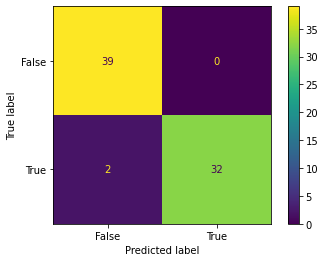

In [53]:
sklearn.metrics.plot_confusion_matrix(isPolicyModel, df_validation['processed_text'].tolist(), df_validation['Ispolicy'].tolist())